<a href="https://colab.research.google.com/github/ruanroloff/my_colab/blob/main/streams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Skmultiflow
from skmultiflow.data.concept_drift_stream import ConceptDriftStream
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
from skmultiflow.data.sine_generator import SineGenerator
from skmultiflow.trees import HoeffdingTreeClassifier

#Utils
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np


# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Gerando dados Sintéticos

In [ ]:
data_generator = ConceptDriftStream(stream=SineGenerator(balance_classes=True, 
                    classification_function=0, random_state=112), 
                                    drift_stream=SineGenerator(balance_classes=True, 
                    classification_function=2, random_state=112), position=15000, width=5000)

data_brute = data_generator.next_sample(30000)
data_final = pd.DataFrame(data_brute[0])
data_final["class"] = data_brute[1]

X_cols = set(data_final.columns) - {"class"}

<AxesSubplot:title={'center':'C'}, xlabel='0', ylabel='1'>

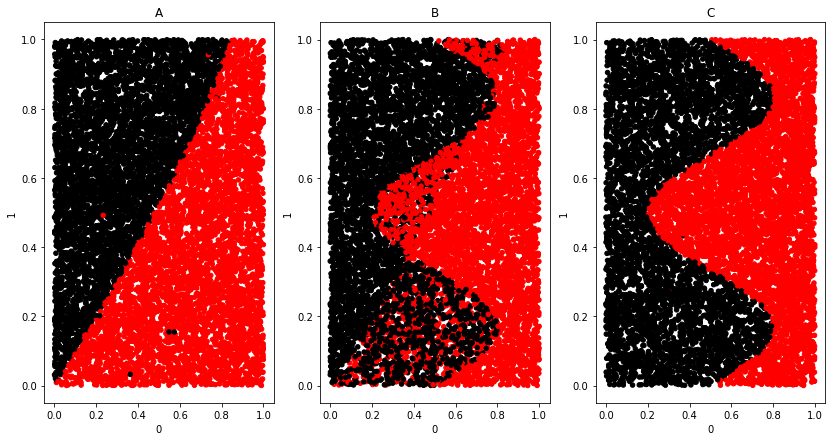

In [ ]:
data_graph = data_final.copy()
data_graph["color"] = np.where(data_final["class"] == 1, "black", "red")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 7))
data_graph.iloc[:10000].plot.scatter(x=0, y=1, c="color", ax=axes[0], title="A")
data_graph.iloc[10000:20000].plot.scatter(x=0, y=1, c="color", ax=axes[1], title="B")
data_graph.iloc[20000:].plot.scatter(x=0, y=1, c="color", ax=axes[2], title = "C")

In [ ]:
initial_batch = int(len(data_final) * 0.025)
data_initial = data_final.iloc[:initial_batch]

In [ ]:
def create__accuray(data: pd.DataFrame) -> pd.DataFrame:
    graph = data.reset_index(drop=True).reset_index()
    graph.rename(columns={"index": "n"}, inplace=True)
    graph["acc"] = np.where(graph["y"] == graph["yhat"], 1, 0)
    graph["acc"] = graph["acc"].cumsum()
    graph["acc"] = graph["acc"]/(graph["n"] + 1)
    return graph

# Modelo em Batch e sem retreino

In [ ]:
# Initial model
model__logistic = LogisticRegression().fit(data_initial[X_cols], data_initial["class"])
model__forest = RandomForestClassifier(max_depth=2).fit(data_initial[X_cols], data_initial["class"])

results = []

for i in tqdm(range(initial_batch, len(data_final))):
    row = data_final.loc[i]
    results.append({"model": "logistic",
                    "y": row["class"], 
                    "yhat": model__logistic.predict([row[X_cols]])[0]})

    results.append({"model": "forest",
                    "y": row["class"], 
                    "yhat": model__forest.predict([row[X_cols]])[0]})

# append results
results = pd.DataFrame(results)
results_logistic = results[results["model"] == "logistic"].copy()
results_forest = results[results["model"] == "forest"].copy()

100%|██████████| 29250/29250 [06:27<00:00, 75.54it/s] 


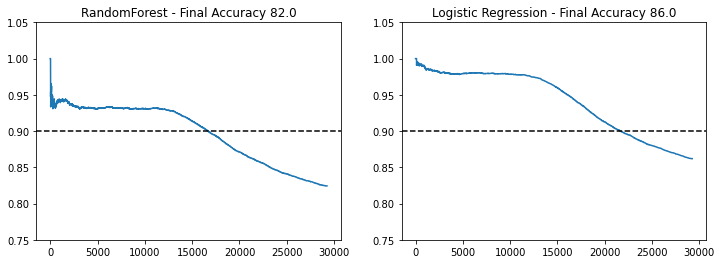

In [ ]:
forest_graph = create__accuray(results_forest)
logistic_graph = create__accuray(results_logistic)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
title_str = ("RandomForest - Final Accuracy %s") % (str(round(accuracy_score(results_forest["y"], results_forest["yhat"]), 2) * 100))
forest_graph["acc"].plot(ax=axes[0], title=title_str, ylim=(0.75, 1.05))
axes[0].axhline(y=0.9, color='k', linestyle='--')

title_str = ("Logistic Regression - Final Accuracy %s") % (str(round(accuracy_score(results_logistic["y"], results_logistic["yhat"]), 2) * 100))
logistic_graph["acc"].plot(ax=axes[1], title=title_str, ylim=(0.75, 1.05))
axes[1].axhline(y=0.9, color='k', linestyle='--')

# Modelo em Batch e com retreino

In [ ]:
# Initial model
model__logistic = LogisticRegression().fit(data_initial[X_cols], data_initial["class"])
model__forest = RandomForestClassifier(max_depth=2).fit(data_initial[X_cols], data_initial["class"])

# results
results = []

# data stream
for i in tqdm(range(initial_batch, len(data_final))):
    row = data_final.loc[i]
    results.append({"model": "logistic",
                    "y": row["class"], 
                    "yhat": model__logistic.predict([row[X_cols]])[0]})

    results.append({"model": "forest",
                    "y": row["class"], 
                    "yhat": model__forest.predict([row[X_cols]])[0]})
    
    if i % 2500 == 0:
        # recent data
        data_buffer = data_final.iloc[i-300:i].reset_index(drop=True)
        
        # retrain model
        model__logistic = LogisticRegression().fit(
                data_buffer[X_cols], data_buffer["class"])
        model__forest = RandomForestClassifier(max_depth=2).fit(
                data_buffer[X_cols], data_buffer["class"])

# append results
results = pd.DataFrame(results)
results_logistic_re = results[results["model"] == "logistic"].copy()
results_forest_re = results[results["model"] == "forest"].copy()

100%|██████████| 29250/29250 [06:14<00:00, 78.14it/s] 


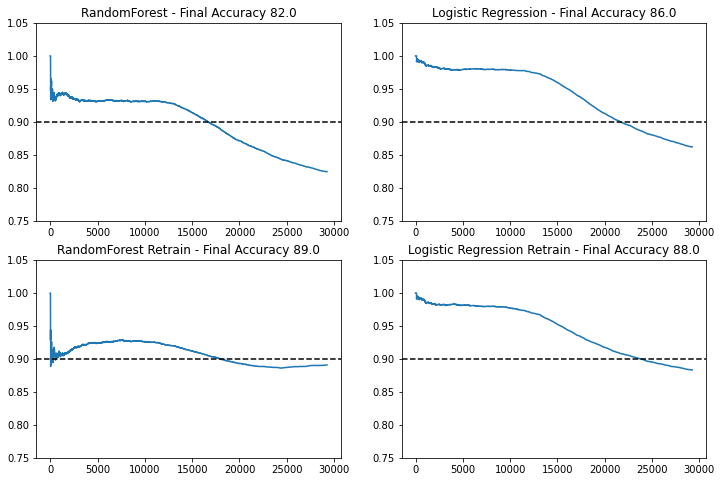

In [ ]:
forest_graph_retrain = create__accuray(results_forest_re)
logistic_graph_retrain = create__accuray(results_logistic_re)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
title_str = ("RandomForest - Final Accuracy %s") % (str(round(accuracy_score(results_forest["y"], results_forest["yhat"]), 2) * 100))
forest_graph["acc"].plot(ax=axes[0][0], title=title_str, ylim=(0.75, 1.05))
axes[0][0].axhline(y=0.9, color='k', linestyle='--')

title_str = ("Logistic Regression - Final Accuracy %s") % (str(round(accuracy_score(results_logistic["y"], results_logistic["yhat"]), 2) * 100))
logistic_graph["acc"].plot(ax=axes[0][1], title=title_str, ylim=(0.75, 1.05))
axes[0][1].axhline(y=0.9, color='k', linestyle='--')

title_str = ("RandomForest Retrain - Final Accuracy %s") % (str(round(accuracy_score(results_forest_re["y"], results_forest_re["yhat"]), 2) * 100))
forest_graph_retrain["acc"].plot(ax=axes[1][0], title=title_str, ylim=(0.75, 1.05))
axes[1][0].axhline(y=0.9, color='k', linestyle='--')

title_str = ("Logistic Regression Retrain - Final Accuracy %s") % (str(round(accuracy_score(logistic_graph_retrain["y"], logistic_graph_retrain["yhat"]), 2) * 100))
logistic_graph_retrain["acc"].plot(ax=axes[1][1], title=title_str, ylim=(0.75, 1.05))
axes[1][1].axhline(y=0.9, color='k', linestyle='--')

# Modelos Incrementais

In [ ]:
# Initial model
model__htc = HoeffdingTreeClassifier()#.fit(data_initial[X_cols], data_initial["class"])
model__hatc = HoeffdingAdaptiveTreeClassifier()#.fit(data_initial[X_cols], data_initial["class"])

# results
results = []

# data stream
for i in tqdm(range(initial_batch, len(data_final))):
    row = data_final.loc[i]
    results.append({"model": "htc",
                    "y": row["class"], 
                    "yhat": model__htc.predict([row[X_cols]])[0]})

    results.append({"model": "hatc",
                    "y": row["class"], 
                    "yhat": model__hatc.predict([row[X_cols]])[0]})
    
    # incremental learning
    model__htc.partial_fit([row[X_cols]], [row["class"]])
    model__hatc.partial_fit([row[X_cols]], [row["class"]])


results = pd.DataFrame(results)
results_htc = results[results["model"] == "htc"].copy()
results_hatc = results[results["model"] == "hatc"].copy()

100%|██████████| 29250/29250 [01:38<00:00, 298.41it/s]


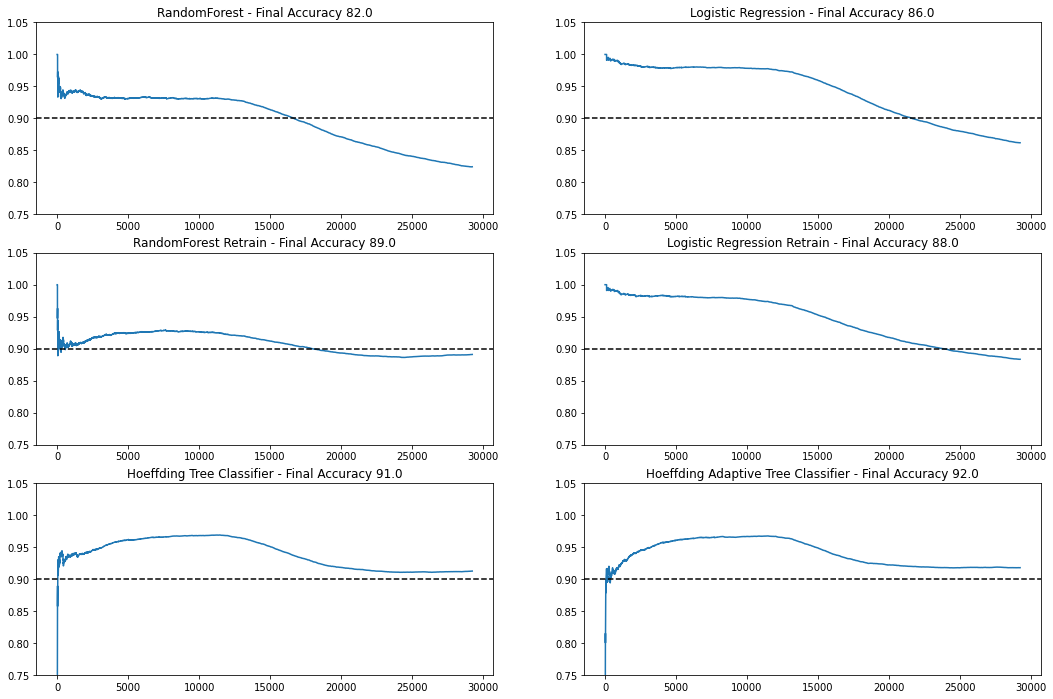

In [ ]:
htc_graph = create__accuray(results_htc)
hatc_graph = create__accuray(results_hatc)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
title_str = ("RandomForest - Final Accuracy %s") % (str(round(accuracy_score(results_forest["y"], results_forest["yhat"]), 2) * 100))
forest_graph["acc"].plot(ax=axes[0][0], title=title_str, ylim=(0.75, 1.05))
axes[0][0].axhline(y=0.9, color='k', linestyle='--')

title_str = ("Logistic Regression - Final Accuracy %s") % (str(round(accuracy_score(results_logistic["y"], results_logistic["yhat"]), 2) * 100))
logistic_graph["acc"].plot(ax=axes[0][1], title=title_str, ylim=(0.75, 1.05))
axes[0][1].axhline(y=0.9, color='k', linestyle='--')

title_str = ("RandomForest Retrain - Final Accuracy %s") % (str(round(accuracy_score(results_forest_re["y"], results_forest_re["yhat"]), 2) * 100))
forest_graph_retrain["acc"].plot(ax=axes[1][0], title=title_str, ylim=(0.75, 1.05))
axes[1][0].axhline(y=0.9, color='k', linestyle='--')

title_str = ("Logistic Regression Retrain - Final Accuracy %s") % (str(round(accuracy_score(logistic_graph_retrain["y"], logistic_graph_retrain["yhat"]), 2) * 100))
logistic_graph_retrain["acc"].plot(ax=axes[1][1], title=title_str, ylim=(0.75, 1.05))
axes[1][1].axhline(y=0.9, color='k', linestyle='--')

title_str = ("Hoeffding Tree Classifier - Final Accuracy %s") % (str(round(accuracy_score(results_htc["y"], results_htc["yhat"]), 2) * 100))
htc_graph["acc"].plot(ax=axes[2][0], title=title_str, ylim=(0.75, 1.05))
axes[2][0].axhline(y=0.9, color='k', linestyle='--')

title_str = ("Hoeffding Adaptive Tree Classifier - Final Accuracy %s") % (str(round(accuracy_score(results_hatc["y"], results_hatc["yhat"]), 2) * 100))
hatc_graph["acc"].plot(ax=axes[2][1], title=title_str, ylim=(0.75, 1.05))
axes[2][1].axhline(y=0.9, color='k', linestyle='--')
